<font face="Rage" size=7 color='#9966CC'> Enhancing Retrival Augmented Generation <font>


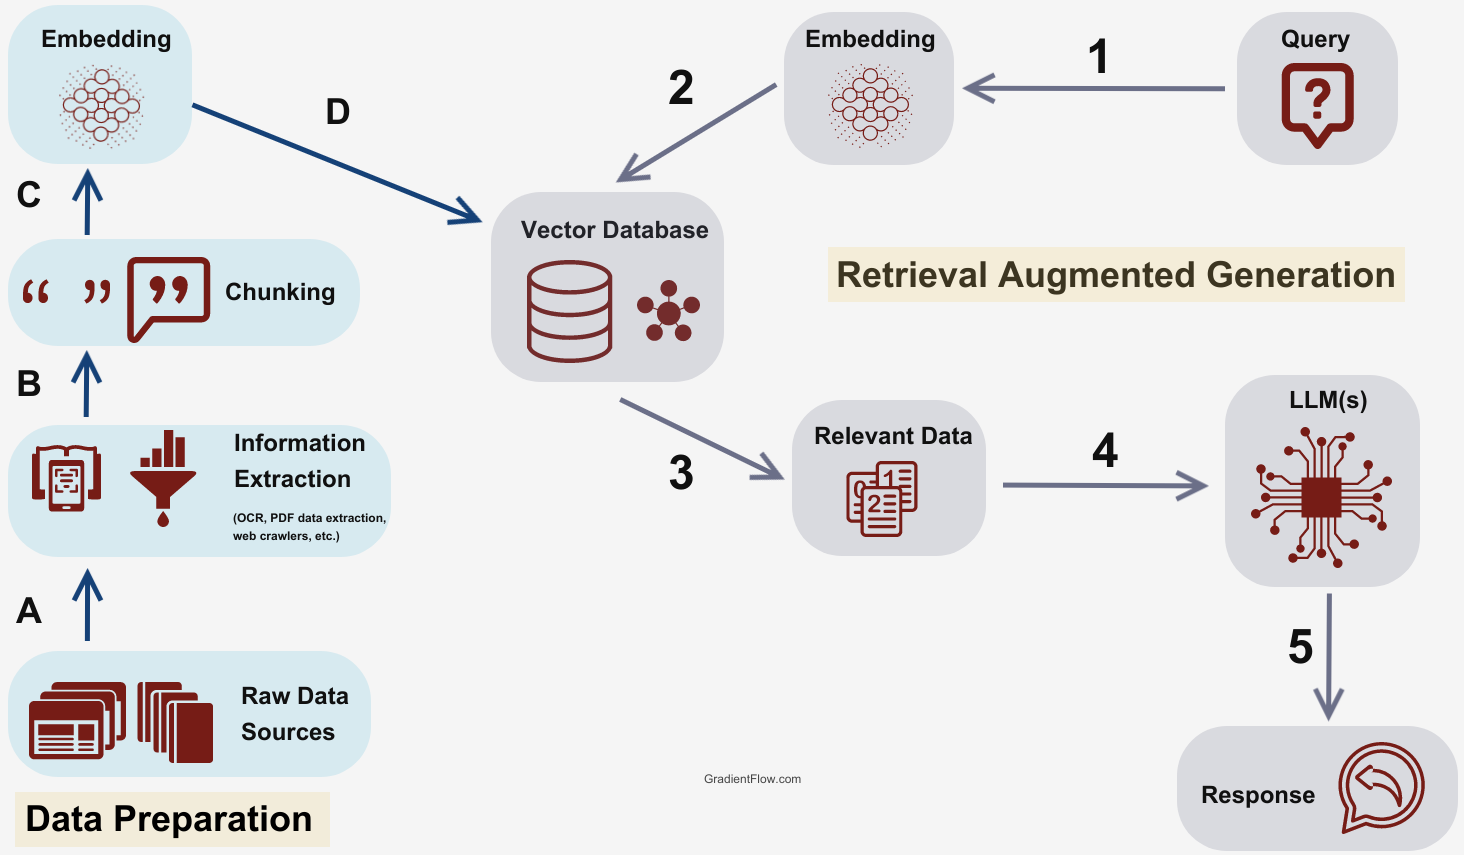

<font face="Rage" size=7 color='#9966CC'>  <font>

#**Stage-1: Multivector Retrival generating Hypothetical Questions, Pre-Embedding Phase**

<font face="Rage" size=7 color='green'> <font>



Storing multiple vectors per document can be advantageous for various use cases. LangChain's base MultiVectorRetriever simplifies querying in such setups. The complexity often lies in generating these multiple vectors per document. This notebook explores common methods for creating these vectors and utilizing the MultiVectorRetriever.

The methods to create multiple vectors per document include:

1. **Smaller chunks**: Splitting a document into smaller sections and embedding each chunk (used in ParentDocumentRetriever).
2. **Summary**: Creating a summary for each document and embedding the summary along with, or instead of, the original document.
3. **Hypothetical questions**: Generating hypothetical questions that the document could answer and embedding these questions along with, or instead of, the document.

Additionally, this approach allows for manual embedding, where specific questions or queries are added to guide document retrieval, providing greater control.

In this case, we'll focus on the third approach: generating hypothetical questions for each document, embedding these questions instead of the document.


<font face="Rage" size=7 color='dark_orange'> <font>

## **Install Dependencies**

In [ ]:
pip install --quiet langchain langchain_community langchain_openai langchain_chroma langchain_core langchain_text_splitters pypdf sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

<font face="Rage" size=7 color='dark_orange'> <font>

## **Imports**

In [ ]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import uuid
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader

In [ ]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

| Name                     | Index Type                    | Uses an LLM  | When to Use                                                                                     | Description                                                                                                                                                                                                                       |
|--------------------------|-------------------------------|--------------|-------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Vectorstore              | Vectorstore                   | No           | If you are just getting started and looking for something<br>quick and easy.                       | This is the simplest method and the one that is easiest to get started with.<br>It creates embeddings for each piece of text.                                                                                                         |
| ParentDocument           | Vectorstore + Document Store  | No           | If your pages have lots of smaller pieces of distinct<br>information that are best indexed by themselves,<br>but best retrieved all together. | This indexes multiple chunks for each document. Then you find the chunks that are most similar<br>in embedding space, but you retrieve the whole parent document and return that<br>(rather than individual chunks).                     |
| Multi Vector             | Vectorstore + Document Store  | Sometimes    | If you are able to extract information from documents<br>that you think is more relevant to index<br>than the text itself.               | This creates multiple vectors for each document. Each vector could be created in a myriad of ways -<br>examples include summaries of the text and hypothetical questions.                                                              |
| Self Query               | Vectorstore                   | Yes          | If users are asking questions that are better answered by fetching<br>documents based on metadata rather than similarity with the text. | This uses an LLM to transform user input into two things: (1) a string to look up semantically,<br>(2) a metadata filer to go along with it. This is useful because oftentimes questions<br>are about the METADATA of documents (not the content itself). |
| Contextual Compression   | Any                           | Sometimes    | If you are finding that your retrieved documents contain too much<br>irrelevant information and are distracting the LLM.              | This puts a post-processing step on top of another retriever and extracts only the most relevant<br>information from retrieved documents. This can be done with embeddings or an LLM.                                                  |
| Time-Weighted Vectorstore| Vectorstore                   | No           | If you have timestamps associated with your documents,<br>and you want to retrieve the most recent ones.                               | This fetches documents based on a combination of semantic similarity<br>(as in normal vector retrieval) and recency (looking at timestamps of indexed documents).                                                                     |
| Multi-Query Retriever    | Any                           | Yes          | If users are asking questions that are complex and require multiple<br>pieces of distinct information to respond.                      | This uses an LLM to generate multiple queries from the original one. This is useful when the original query<br>needs pieces of information about multiple topics to be properly answered.<br>By generating multiple queries, we can then fetch documents for each of them. |
| Ensemble                 | Any                           | No           | If you have multiple retrieval methods and want to try combining them.                                                               | This fetches documents from multiple retrievers and then combines them.                                                                                                                                                           |
| Long-Context Reorder     | Any                           | No           | If you are working with a long-context model and noticing that it's not paying<br>attention to information in the middle of retrieved documents. | This fetches documents from an underlying retriever, and then reorders them so that the most similar<br>are near the beginning and end. This is useful because it's been shown that for longer context models<br>they sometimes don't pay attention to information in the middle of the context window. |


<font face="Rage" size=7 color='green'><font>

## **MultiVectorRetriever**



<font face="Rage" size=7 color='green'><font>


We are setting up a MultiVectorRetriever in LangChain, a framework for building applications with language models. Here's an explanation of each component:

1. **MultiVectorRetriever**: This class is part of LangChain and is used to retrieve documents by querying multiple vectors. Each document can be represented by multiple embeddings, improving the accuracy of search and retrieval operations.

2. **InMemoryByteStore**: This module is used to store the document embeddings in memory. It's a simple and efficient way to handle embeddings during development and testing, ensuring that data can be quickly accessed and modified.

3. **Chroma**: This component integrates with the Chroma library, which is commonly used for creating and managing vector stores. Chroma helps in indexing and searching through vector representations of documents efficiently.

4. **TextLoader**: This module is used to load text documents into the LangChain framework. It reads text files and prepares them for embedding and storage.

5. **OpenAIEmbeddings**: This class interfaces with OpenAI's embedding models. It converts documents or text chunks into vector embeddings using OpenAI's powerful language models.

6. **RecursiveCharacterTextSplitter**: This utility is used to split documents into smaller chunks. It recursively divides text based on character limits, ensuring that each chunk is a manageable size for embedding and processing.

7. **uuid**: This module generates unique identifiers. It is used to assign unique IDs to documents, ensuring each one can be distinctly identified in the vector store.

8. **Document**: This class represents a document in the LangChain framework. It encapsulates the content and metadata of a document, making it easy to manage and process.

9. **StrOutputParser**: This component parses the output from language models into strings. It ensures the responses from language models are correctly formatted and easy to work with.

10. **ChatPromptTemplate**: This class is used to create templates for chat prompts. It allows for dynamic generation of prompts, which can be useful when interacting with language models in conversational settings.

11. **ChatOpenAI**: This module integrates with OpenAI's chat models, enabling conversational interactions with language models. It facilitates generating responses to queries and prompts in a natural, chat-like format.

12. **PyPDFLoader**: This module is designed to load PDF documents into the LangChain framework. It reads PDF files, extracts the text, and prepares it for embedding and further processing.

Together, these components form a robust setup for creating and managing a document retrieval system that leverages multiple vectors per document. By embedding documents in various ways—such as through smaller chunks, summaries, or hypothetical questions—the MultiVectorRetriever can provide more accurate and relevant search results.

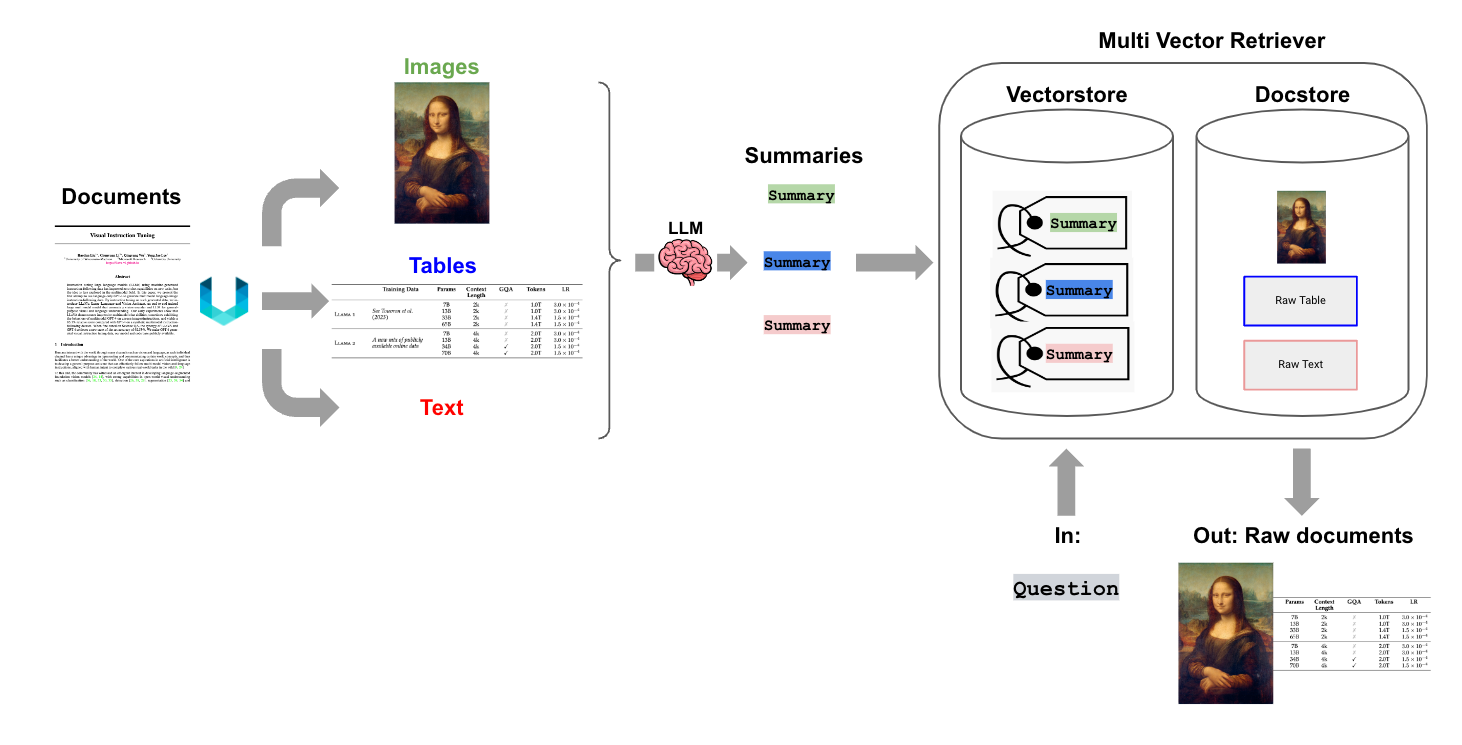

<font face="Rage" size=7 color='green'><font>

## **Chunking Phase**

In [ ]:
loader = PyPDFLoader("/content/Streamlit with Databricks.pdf").load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500)
docs = text_splitter.split_documents(loader)

In [ ]:
docs

In [ ]:
# bm25_retriever = BM25Retriever.from_texts(
#     doc_list_1, metadatas=[{"source": 1}] * len(doc_list_1)
# )
# bm25_retriever.k =

In [ ]:
# retriever#multivectr_retriever

In [ ]:
# ensemble_retriever = EnsembleRetriever(
#     retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5]
# )

In [ ]:
len(docs)

9

<font face="Rage" size=7 color='green'><font>
## **Embedding And Retrieval - ChromaDB**

<font face="Rage" size=7 color='green'><font>

### **Setting up MultiVectorRetrival**

In [ ]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="multiple_vectors", embedding_function=OpenAIEmbeddings()
)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

<font face="Rage" size=7 color='green'><font>

Now we set up the components necessary to index and store document chunks and to initialize a multi-vector retriever. Here's an explanation of each part:

1. **Chroma**: This component creates a vector store to index the document chunks. It uses the Chroma library to handle the vectors.

    ```python
    vectorstore = Chroma(
        collection_name="multiple_questions", embedding_function=OpenAIEmbeddings()
    )
    ```

    - **collection_name**: The name of the collection in the vector store.
    - **embedding_function**: The function used to generate embeddings, here it's `OpenAIEmbeddings()`.

2. **InMemoryByteStore**: This creates an in-memory storage layer for the parent documents. It's efficient for development and testing.

    ```python
    store = InMemoryByteStore()
    ```

3. **id_key**: This key is used to uniquely identify documents in the storage layer.

    ```python
    id_key = "doc_id"
    ```

4. **MultiVectorRetriever**: This component initializes the retriever that will use the vector store and the byte store to handle document retrieval.

    ```python
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        byte_store=store,
        id_key=id_key,
    )
    ```

    - **vectorstore**: The vector store initialized earlier.
    - **byte_store**: The in-memory byte store for parent documents.
    - **id_key**: The unique identifier key for documents.

5. **doc_ids**: This line generates unique identifiers for each document chunk.

    ```python
    doc_ids = [str(uuid.uuid4()) for _ in docs]
    ```

    - **str(uuid.uuid4())**: Generates a unique UUID and converts it to a string.
    - **for _ in docs**: Creates a unique ID for each document chunk.



<font face="Rage" size=7 color='green'><font>
## **Multi-Vector Grneration**

<font face="Rage" size=7 color='green'><font>
### **Generating Smaller Chunks**

In [ ]:
# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

In [ ]:
sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

In [ ]:
sub_docs

[Document(page_content='STREAMLIT\nAPPS WITH \nDATABRICKS \nML apps that can have\npowerful backend support\nwith Databricks', metadata={'source': '/content/Streamlit with Databricks.pdf', 'page': 0, 'doc_id': '358b89ce-d8a2-44ea-8258-b137c4dc9768'}),
 Document(page_content='COMMON USES OF \nDATABRICKS\n•Databricks is commonly used for big data analytics and \nprocessing, particularly for Apache Spark-based data \nprocessing tasks. It provides a unified analytics platform', metadata={'source': '/content/Streamlit with Databricks.pdf', 'page': 1, 'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 Document(page_content='processing, particularly for Apache Spark-based data \nprocessing tasks. It provides a unified analytics platform \nthat integrates with various data sources and supports', metadata={'source': '/content/Streamlit with Databricks.pdf', 'page': 1, 'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 Document(page_content="processing tasks. It provides a unified analytics 

In [ ]:
len(sub_docs)

40

<font face="Rage" size=7 color='green'><font>
### **Generating Summaries**

In [ ]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(max_retries=0)
    | StrOutputParser()
)

In [ ]:
summaries = chain.batch(docs, {"max_concurrency": 5})

In [ ]:
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

In [ ]:
summary_docs

[Document(page_content='The document discusses creating Streamlit apps with powerful backend support using Databricks for machine learning applications.', metadata={'doc_id': '358b89ce-d8a2-44ea-8258-b137c4dc9768'}),
 Document(page_content='Databricks is commonly used for big data analytics and processing, especially for Apache Spark-based tasks. It is a unified analytics platform that integrates with different data sources and supports collaborative data science workflows. It is also used for machine learning, data engineering, and real-time analytics applications.', metadata={'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 Document(page_content='processing and analysis, but using it as a hosting platform for a Streamlit app may not provide the best performance or user experience. It is recommended to use other platforms like Heroku or AWS for hosting Streamlit apps for better performance and scalability.', metadata={'doc_id': '6e82c770-5832-410f-aabf-9a2e6c00ea62'}),
 Document(p

In [ ]:
len(summary_docs)

9

<font face="Rage" size=7 color='green'><font>
### **Generating Hypothetical Questions**

In [ ]:
functions = [
    {
        "name": "hypothetical_questions",
        "description": "Generate hypothetical questions",
        "parameters": {
            "type": "object",
            "properties": {
                "questions": {
                    "type": "array",
                    "items": {"type": "string"},
                },
            },
            "required": ["questions"],
        },
    }
]

In [ ]:
chain = (
    {"doc": lambda x: x.page_content}
    # Only asking for 3 hypothetical questions, but this could be adjusted
    | ChatPromptTemplate.from_template(
        "Generate a list of exactly 3 hypothetical questions that the below document could be used to answer:\n\n{doc}"
    )
    | ChatOpenAI(max_retries=0, model="gpt-3.5-turbo").bind(
        functions=functions, function_call={"name": "hypothetical_questions"}
    )
    | JsonKeyOutputFunctionsParser(key_name="questions")
)

In [ ]:
chain.invoke(docs[0])

['How can Streamlit be used to create apps with powerful backend support using Databricks?',
 'What are the advantages of using Databricks with Streamlit for developing ML apps?',
 'How can Databricks enhance the functionality of ML apps created with Streamlit?']

In [ ]:
hypothetical_questions = chain.batch(docs, {"max_concurrency": 5})


In [ ]:
question_docs = []
for i, question_list in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=s, metadata={id_key: doc_ids[i]}) for s in question_list]
    )

In [ ]:
question_docs

[Document(page_content='How can Streamlit be used to create apps with Databricks backend support?', metadata={'doc_id': '358b89ce-d8a2-44ea-8258-b137c4dc9768'}),
 Document(page_content='What are the benefits of using Streamlit and Databricks for ML applications?', metadata={'doc_id': '358b89ce-d8a2-44ea-8258-b137c4dc9768'}),
 Document(page_content='How can Databricks be integrated with Streamlit for powerful backend support in ML apps?', metadata={'doc_id': '358b89ce-d8a2-44ea-8258-b137c4dc9768'}),
 Document(page_content='How is Databricks commonly used for big data analytics and processing?', metadata={'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 Document(page_content='In what ways does Databricks support collaborative data science workflows?', metadata={'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 Document(page_content='What are the applications of Databricks in machine learning and real-time analytics?', metadata={'doc_id': 'b7b66fc2-5734-4796-8d63-afa98a876536'}),
 

In [ ]:
len(question_docs)

27

We are defining a list of functions, with one function in this case, described in a structured format.

1. **functions**: This is a list that contains definitions of various functions. In this example, it includes a single function definition.

2. **{
    "name": "hypothetical_questions",
    "description": "Generate hypothetical questions",
    "parameters": {
        "type": "object",
        "properties": {
            "questions": {
                "type": "array",
                "items": {"type": "string"},
            },
        },
        "required": ["questions"],
    }
}**: This dictionary defines a function with the following details:

    - **name**: The name of the function is "hypothetical_questions". This is the identifier used to refer to this function.

    - **description**: A brief description of the function, explaining that it is used to generate hypothetical questions.

    - **parameters**: This section defines the parameters that the function accepts:
        - **type**: The type of the parameters object. In this case, it is "object".
        - **properties**: A dictionary that describes the properties of the parameters object:
            - **questions**: This property is an array (list) of strings. It indicates that the function expects a list of questions as input.
        - **required**: A list of required properties. Here, "questions" is a required property, meaning the function must be provided with this parameter.




<font face="Rage" size=7 color='green'><font>

This defines a chain of operations to generate hypothetical questions for a given document using LangChain components.

1. **JsonKeyOutputFunctionsParser**: This module is imported from `langchain.output_parsers.openai_functions` and is used to parse the output JSON from the OpenAI model, specifically extracting the value associated with a specified key.

2. **chain**: This variable defines a sequence of operations (a chain) to process a document and generate hypothetical questions.

3. **{"doc": lambda x: x.page_content}**: This lambda function extracts the `page_content` attribute from the document object, which represents the text content of the document.

4. **ChatPromptTemplate.from_template(...)**: This creates a prompt template for generating hypothetical questions. The template string instructs the model to generate a list of exactly 3 hypothetical questions that the document could answer. The `{doc}` placeholder is replaced with the actual document content.

5. **ChatOpenAI(...)**: This component integrates with OpenAI's GPT-3.5-turbo model. It sets the maximum number of retries to 0 (i.e., no retries on failure) and specifies the model to use. It also binds the function definitions (from the `functions` list) and specifies that the function call should use the "hypothetical_questions" function.

6. **JsonKeyOutputFunctionsParser(key_name="questions")**: This parser extracts the "questions" key from the JSON output produced by the OpenAI model. It ensures that the output is correctly parsed and the hypothetical questions are extracted.

The overall chain performs the following steps:

1. Extract the text content from the document.
2. Generate a prompt asking for 3 hypothetical questions that the document could answer.
3. Use the GPT-3.5-turbo model to generate these questions.
4. Parse the output to extract the list of questions.

<font face="Rage" size=7 color='green'><font>

## **Embedding with ID's in Vectorstore**

In [ ]:
embed_docs=sub_docs+summary_docs+question_docs

In [ ]:
len(embed_docs)

76

In [ ]:
retriever.vectorstore.add_documents(embed_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

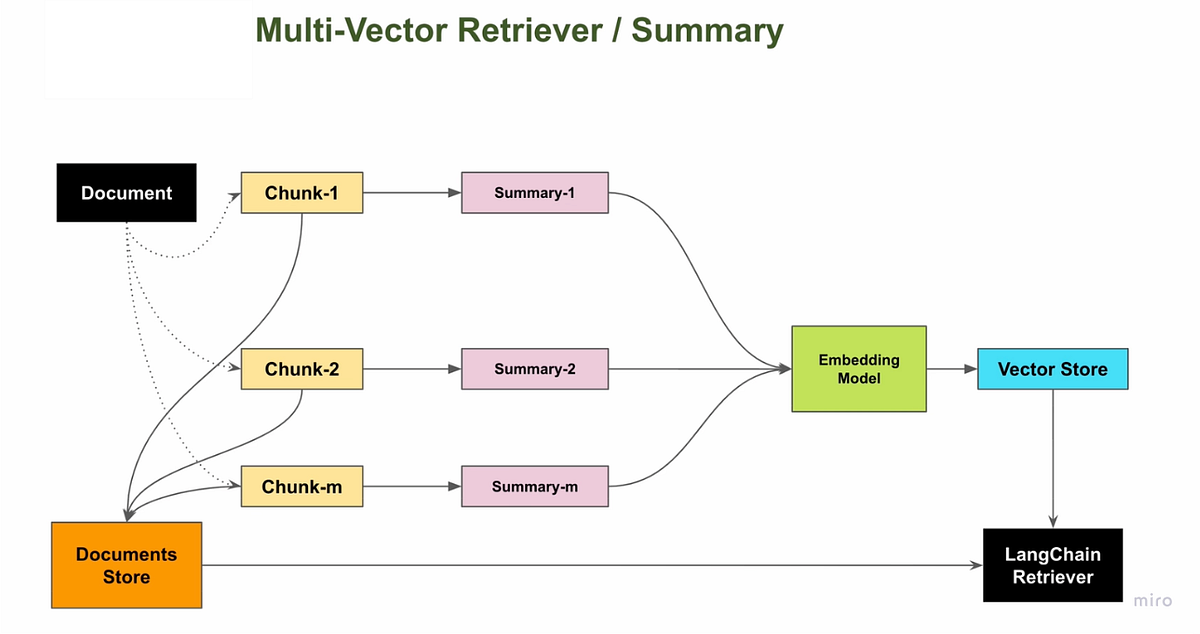

<font face="Rage" size=7 color='green'><font>

We prepare the document chunks and hypothetical questions for indexing and storage in the retriever's vector store and document store. Here's what each part does:

1. **Loop through Hypothetical Questions**: This loop iterates through the list of hypothetical questions generated for each document chunk.

    ```python
    question_docs = []
    for i, question_list in enumerate(hypothetical_questions):
    ```

2. **Create Document Objects**: For each list of hypothetical questions, document objects are created. Each document object contains one hypothetical question, along with the corresponding document ID as metadata.

    ```python
        question_docs.extend(
            [Document(page_content=s, metadata={id_key: doc_ids[i]}) for s in question_list]
        )
    ```

3. **Add Documents to Vector Store**: The document objects representing the hypothetical questions are added to the retriever's vector store.

    ```python
    retriever.vectorstore.add_documents(question_docs)
    ```

4. **Add Parent Documents to Document Store**: The original document chunks are added to the retriever's document store, using their corresponding document IDs.

    ```python
    retriever.docstore.mset(list(zip(doc_ids, docs)))
    ```

In summary, this code segment organizes the hypothetical questions and document chunks into appropriate data structures and stores them in the retriever's vector store and document store. This enables efficient indexing and retrieval of documents and associated hypothetical questions, facilitating accurate search operations within the LangChain framework.


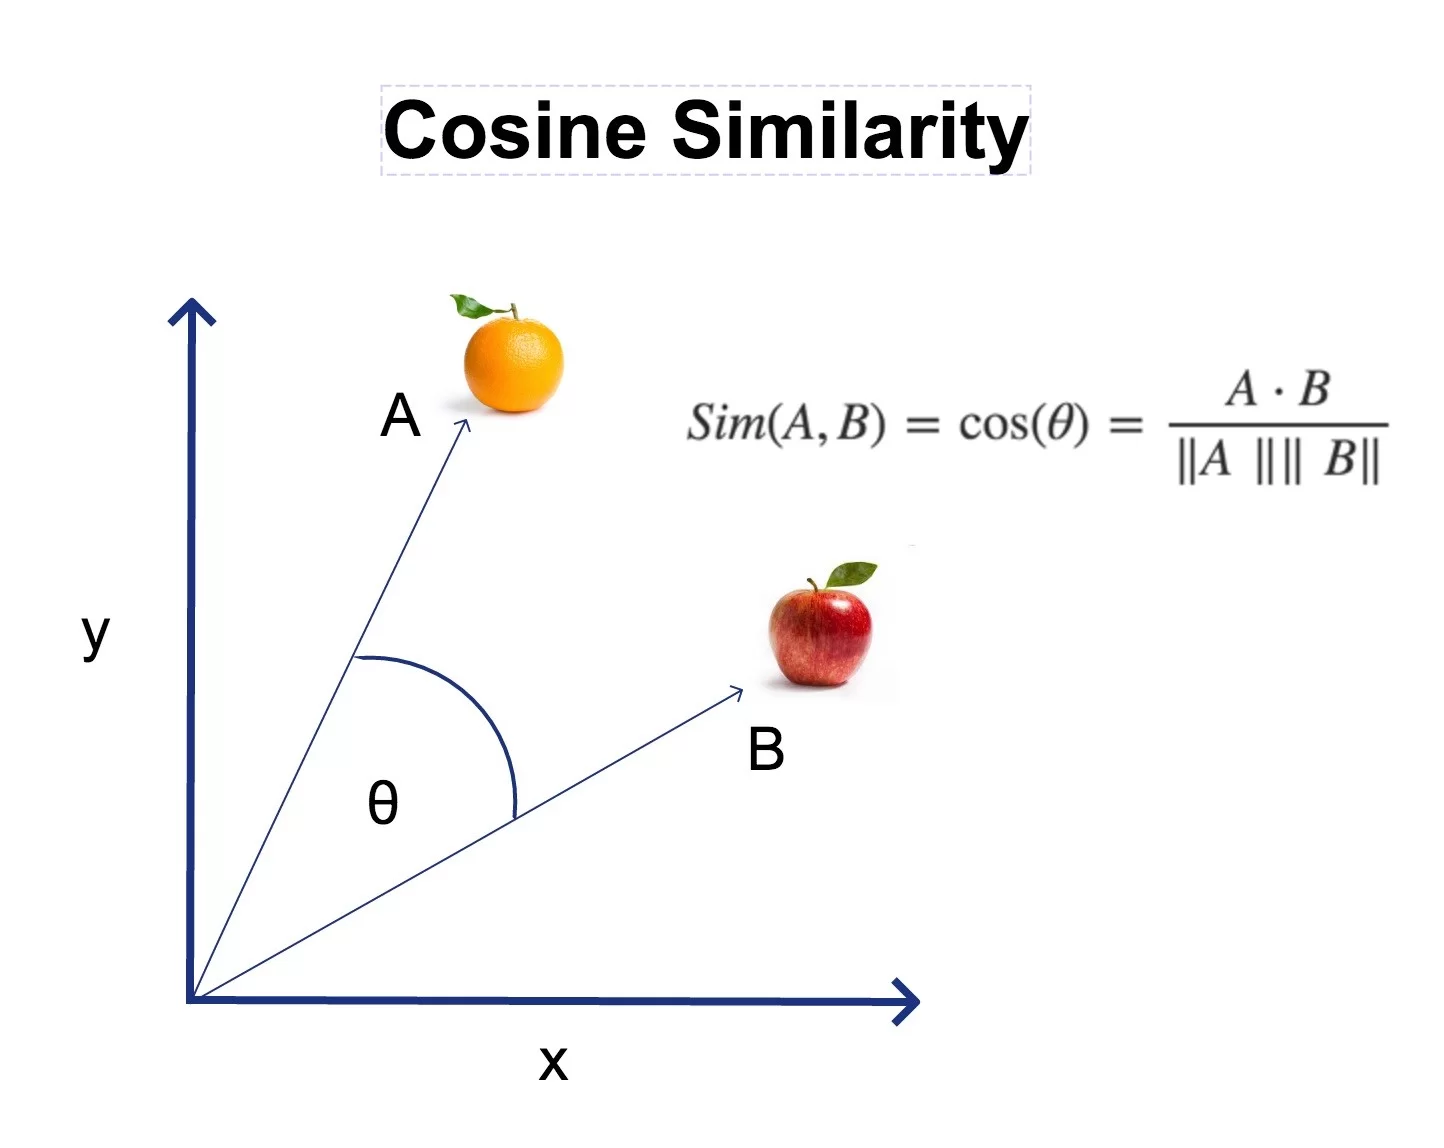

In [ ]:
sub_docs1 = vectorstore.similarity_search("streamlit and databricks in data analytics ")

In [ ]:
# Helper function for printing docs


def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [ ]:
pretty_print_docs(sub_docs1)

Document 1:

Streamlit app for data processing tasks by 
leveraging Databricks as a backend service. 
For example, you can use Databricks for 
heavy-duty data transformations, machine
----------------------------------------------------------------------------------------------------
Document 2:

STREAMLIT
APPS WITH 
DATABRICKS 
ML apps that can have
powerful backend support
with Databricks
----------------------------------------------------------------------------------------------------
Document 3:

STREAMLIT
This integration allows you to offload 
resource-intensive tasks to Databricks, 
which is optimized for big data processing, 
while still providing a user-friendly interface
----------------------------------------------------------------------------------------------------
Document 4:

The document discusses the integration of Databricks into Streamlit, allowing users to leverage Databricks' capabilities for resource-intensive tasks while using Streamlit for a user-friendly in

In [ ]:
retrieved_docs = retriever.invoke("streamlit with databricks")

In [ ]:
len(retrieved_docs[0].page_content)

455

In [ ]:
pretty_print_docs(retrieved_docs)

Document 1:

INTEGRATING 
DATABRICKS INTO 
STREAMLIT
•We can integrate Databricks into your 
Streamlit app for data processing tasks by 
leveraging Databricks as a backend service. 
For example, you can use Databricks for 
heavy-duty data transformations, machine 
learning model training, or large-scale data 
analysis tasks. Your Streamlit app can 
communicate with Databricks through its 
REST API or by using Databricks libraries 
directly within your Python code.
----------------------------------------------------------------------------------------------------
Document 2:

INTEGRATING 
DATABRICKS INTO 
STREAMLIT
This integration allows you to offload 
resource-intensive tasks to Databricks, 
which is optimized for big data processing, 
while still providing a user-friendly interface 
through Streamlit for interacting with and 
visualizing the results of these tasks. It's a 
powerful combination that combines the 
strengths of both platforms for a seamless 
data processing and analys

<font face="Rage" size=7 color='orange'><font>

# **Stage-2: Generation, Implementing RAG**

We are going to now integrate a contextual compression retriever to improve document retrieval and uses a chain to summarize the retrieved documents.

1. **Initialize and Configure Models**: Set up the cross-encoder model and re-ranker.
2. **Set Up Compression Retriever**: Combine the base retriever with the re-ranker to create a contextual compression retriever.
3. **Retrieve Compressed Documents**: Use the compression retriever to get the top relevant documents for the query "streamlit with databricks".
4. **Print Retrieved Documents**: Display the retrieved documents in a readable format.
5. **Define and Execute Summarization Chain**: Create a chain to summarize the documents and print the summaries.





<font face="Rage" size=7 color='green'><font>

## **Cross Encoder Reranker**

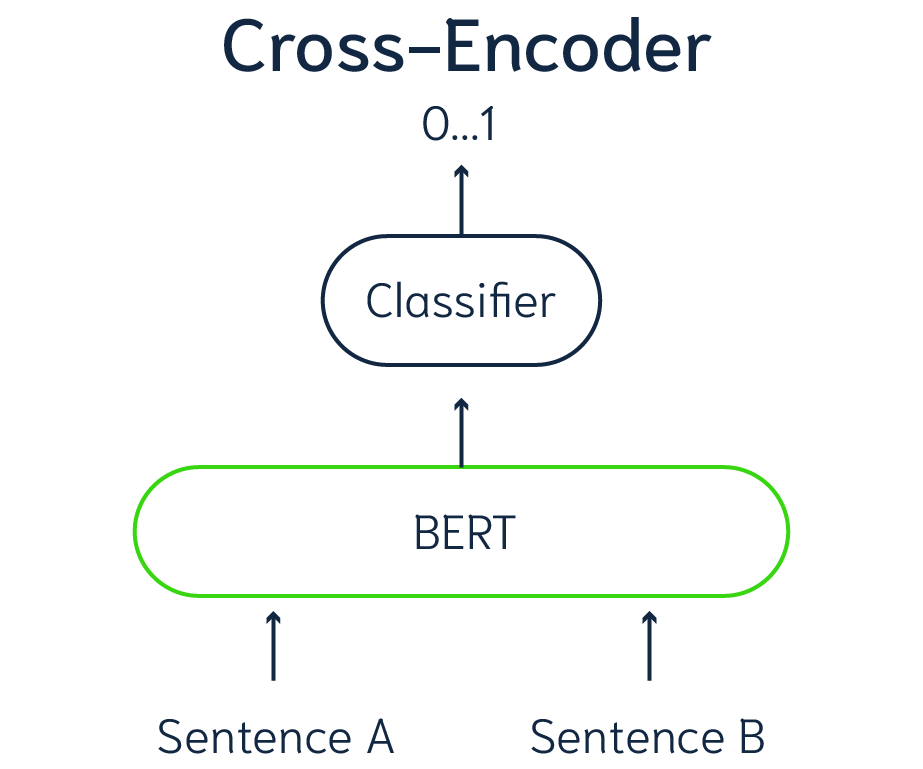

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
compressor = CrossEncoderReranker(model=model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.invoke("streamlit with databricks")
pretty_print_docs(compressed_docs)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authenticatio

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Document 1:

INTEGRATING 
DATABRICKS INTO 
STREAMLIT
This integration allows you to offload 
resource-intensive tasks to Databricks, 
which is optimized for big data processing, 
while still providing a user-friendly interface 
through Streamlit for interacting with and 
visualizing the results of these tasks. It's a 
powerful combination that combines the 
strengths of both platforms for a seamless 
data processing and analysis experience.
----------------------------------------------------------------------------------------------------
Document 2:

INTEGRATING 
DATABRICKS INTO 
STREAMLIT
•We can integrate Databricks into your 
Streamlit app for data processing tasks by 
leveraging Databricks as a backend service. 
For example, you can use Databricks for 
heavy-duty data transformations, machine 
learning model training, or large-scale data 
analysis tasks. Your Streamlit app can 
communicate with Databricks through its 
REST API or by using Databricks libraries 
directly within you

<font face="Rage" size=7 color='magenta'><font>

## **Define RAG Chain**:

This chain is used to summarize each compressed document. It includes a series of operations:
    -

1.   Extract the page content from the document.
2.   Generate a prompt to summarize the document.
1.   Use the ChatOpenAI model to generate the summary.
2.   Parse the output string.


In [ ]:
rag_chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(max_retries=0)
    | StrOutputParser()
)

In [ ]:
for i in range(0,len(compressed_docs)):
  op=rag_chain.invoke(compressed_docs[i])
  print(op)

This document discusses the integration of Databricks into Streamlit, allowing users to offload resource-intensive tasks to Databricks for big data processing while still using Streamlit as a user-friendly interface for interacting with and visualizing the results. This combination enhances data processing and analysis capabilities by leveraging the strengths of both platforms.
This document explains how Databricks can be integrated into a Streamlit app for data processing tasks. By leveraging Databricks as a backend service, tasks such as data transformations, machine learning model training, and large-scale data analysis can be performed. The Streamlit app can communicate with Databricks through its REST API or by using Databricks libraries within Python code.
The document discusses the combination of Streamlit apps with Databricks to create machine learning applications with strong backend support. This integration allows for the development of powerful ML applications using the res